In [1]:
!pip install yacs
!pip install gdown

In [2]:
import os, sys, time
import argparse
import importlib
from tqdm.notebook import tqdm
from imageio import imread
import torch
import numpy as np
import matplotlib.pyplot as plt

### Download pretrained
- We use HoHoNet w/ hardnet encoder in this demo
- Download other version [here](https://drive.google.com/drive/folders/1raT3vRXnQXRAQuYq36dE-93xFc_hgkTQ?usp=sharing)

In [3]:
PRETRAINED_PTH = 'ckpt/s2d3d_sem_HOHO_depth_dct_efficienthc_TransEn1_h1024_fold1_resnet101rgb/ep60.pth'

if not os.path.exists(PRETRAINED_PTH):
    os.makedirs(os.path.split(PRETRAINED_PTH)[0], exist_ok=True)
    !gdown 'https://drive.google.com/uc?id=1w31WOzQvvGjoCXXFmnkeOL035hx7NJRQ' -O $PRETRAINED_PTH

Downloading...
From: https://drive.google.com/uc?id=1w31WOzQvvGjoCXXFmnkeOL035hx7NJRQ
To: /home/kike/Documents/Research/HoHoNet/ckpt/s2d3d_sem_HOHO_depth_dct_efficienthc_TransEn1_h1024_fold1_resnet101rgb/ep60.pth
278MB [00:03, 76.7MB/s] 


### Download image
- We use a out-of-distribution image from PanoContext

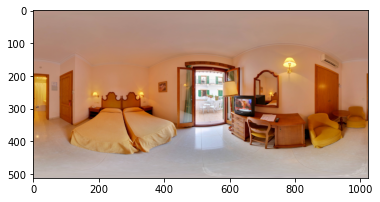

In [4]:
if not os.path.exists('assets/pano_asmasuxybohhcj.png'):
    !gdown 'https://drive.google.com/uc?id=1CXl6RPK6yPRFXxsa5OisHV9KwyRcejHu' -O 'assets/pano_asmasuxybohhcj.png'

rgb = imread('assets/pano_asmasuxybohhcj.png')

plt.imshow(rgb)
plt.show()

### Load model config
- We use HoHoNet w/ hardnet encoder in this demo
- Find out other version in `mp3d_depth/` and `s2d3d_depth`

In [5]:
from lib.config import config

config.defrost()
config.merge_from_file('config/s2d3d_sem/HOHO_depth_dct_efficienthc_TransEn1_h1024_fold1_resnet101rgb.yaml')
config.model.kwargs.modalities_config.SemanticSegmenter.label_weight = ''
config.freeze()

### Load model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('devcie:', device)

model_file = importlib.import_module(config.model.file)
model_class = getattr(model_file, config.model.modelclass)
net = model_class(**config.model.kwargs)
net.load_state_dict(torch.load(PRETRAINED_PTH, map_location=device))
net = net.eval().to(device)

devcie: cuda


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/kike/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

### Move image into tensor, normzlie to [0, 255], resize to training resolution

In [7]:
x = torch.from_numpy(rgb).permute(2,0,1)[None].float() / 255.
if x.shape[2:] != config.dataset.common_kwargs.hw:
    x = torch.nn.functional.interpolate(x, config.dataset.common_kwargs.hw, mode='area')
x = x.to(device)

### Model feedforward

In [8]:
with torch.no_grad():
    ts = time.time()
    pred_sem = net.infer(x)['sem']
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    print(f'Eps time: {time.time() - ts:.2f} sec.')

Eps time: 0.30 sec.


### Visualize result in 2d

In [9]:
color_map = np.array([
    [  0,   0,   0],
    [255,   0,  40],
    [255,  72,   0],
    [255, 185,   0],
    [205, 255,   0],
    [ 91, 255,   0],
    [  0, 255,  21],
    [  0, 255, 139],
    [  0, 255, 252],
    [  0, 143, 255],
    [  0,  23, 255],
    [ 90,   0, 255],
    [204,   0, 255],
    [255,   0, 191]], dtype=np.uint8)

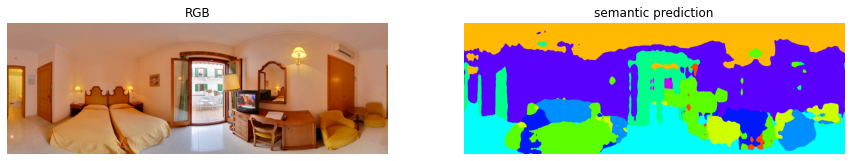

In [10]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.imshow(rgb[80:-80])
plt.axis('off')
plt.title('RGB')

plt.subplot(122)
plt.imshow(color_map[pred_sem.squeeze().cpu().numpy().argmax(0)[160:-160]])
plt.axis('off')
plt.title('semantic prediction')

plt.show()